In [92]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [93]:
codes_list = ['ZCN24.CBT','ZCU24.CBT', 'ZCZ24.CBT','ZCH25.CBT','ZCK25.CBT','ZCN25.CBT','ZCU25.CBT','ZCZ25.CBT','ZCH26.CBT','ZCK26.CBT','ZCN26.CBT','ZCU26.CBT','ZCZ26.CBT']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts until end of 2026), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    dfs_list.append(i_df)


In [94]:
vix_code = '^VIX'
vix_ticker= yf.Ticker(vix_code)

vix_df = vix_ticker.history(start='2020-12-15')
vix_df.index = vix_df.index.date
vix_df['vix'] = vix_df['Close'] 


In [95]:
dow_code = 'YM=F'
dow_ticker = yf.Ticker(dow_code)

dow_df = dow_ticker.history(start = '2020-12-15')
dow_df.index = dow_df.index.date
dow_df['dow'] = dow_df['Close']
#dow jones e-mini continous cbot contracts 
#not a lot of improvement in r^2 but maybe will be better in RF once we get interaction terms

In [96]:
# Variables 
for i, df in enumerate(dfs_list):    
    # Daily Returns
    df.index = df.index.date
    df['Returns'] = df['Close'].pct_change() * 100

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-28)
    print(df['Month Returns'])

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    df = pd.merge(df, vix_df['vix'], left_index=True, right_index=True)
    df = pd.merge(df, dow_df['dow'], left_index=True, right_index=True)

    df = df.dropna()
    dfs_list[i] = df  # Assign the modified df back to the list


dfs_dct = dict(zip(codes_list, dfs_list))

2020-12-14    4.551201
2020-12-15    3.853443
2020-12-16    3.398364
2020-12-17    4.082915
2020-12-18    4.328733
                ...   
2024-06-11         NaN
2024-06-12         NaN
2024-06-13         NaN
2024-06-14         NaN
2024-06-17         NaN
Name: Month Returns, Length: 882, dtype: float64
2021-12-14   -0.441176
2021-12-15   -0.393120
2021-12-16   -1.226091
2021-12-17   -0.736377
2021-12-20   -1.131333
                ...   
2024-06-11         NaN
2024-06-12         NaN
2024-06-13         NaN
2024-06-14         NaN
2024-06-17         NaN
Name: Month Returns, Length: 630, dtype: float64
2020-12-14    3.792668
2020-12-15    3.095389
2020-12-16    2.643172
2020-12-17    3.329146
2020-12-18    3.324969
                ...   
2024-06-11         NaN
2024-06-12         NaN
2024-06-13         NaN
2024-06-14         NaN
2024-06-17         NaN
Name: Month Returns, Length: 882, dtype: float64
2022-12-14   -2.465874
2022-12-15   -3.030303
2022-12-16   -1.894273
2022-12-19   -1.541850
20

In [97]:
#OLS

def ols(merged_df):
    #Specifying Axes 
    x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP','vix','dow']
    X = merged_df.loc[:, x_vars] #Selecting only from merged_df
    y = merged_df['Month Returns']
    
    #Training and Testing Data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Add constant term to X_train and X_test
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    # Fit the OLS model
    model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
    y_pred = model.predict(X_test) 
    
    #Model Evaluations 

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
    mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
    print(model.summary())
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error(MSE): {mse:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.title('Actual vs Predicted')
    plt.show()
    return model

OLS Summary ZCN24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     18.80
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.93e-32
Time:                        16:45:28   Log-Likelihood:                -1199.1
No. Observations:                 410   AIC:                             2424.
Df Residuals:                     397   BIC:                             2476.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

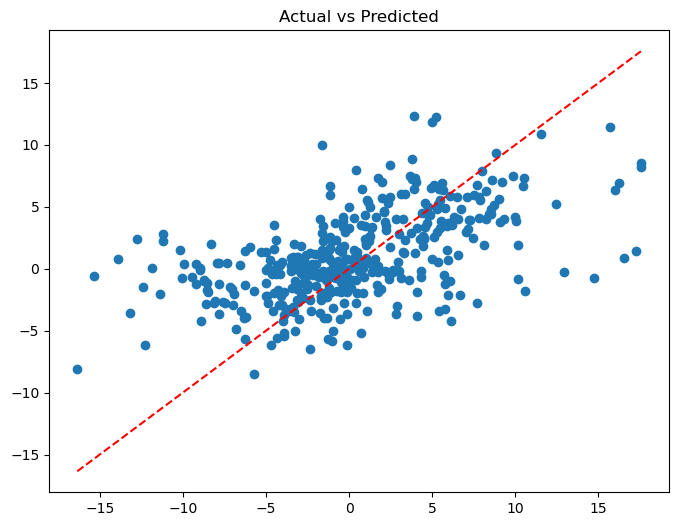



OLS Summary ZCU24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     13.07
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           4.35e-21
Time:                        16:45:29   Log-Likelihood:                -775.60
No. Observations:                 282   AIC:                             1577.
Df Residuals:                     269   BIC:                             1625.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

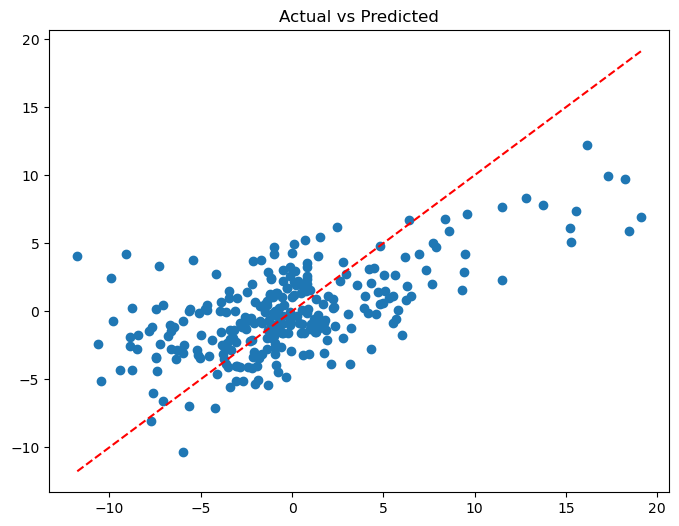



OLS Summary ZCZ24.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     17.84
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.01e-30
Time:                        16:45:30   Log-Likelihood:                -1116.3
No. Observations:                 410   AIC:                             2259.
Df Residuals:                     397   BIC:                             2311.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

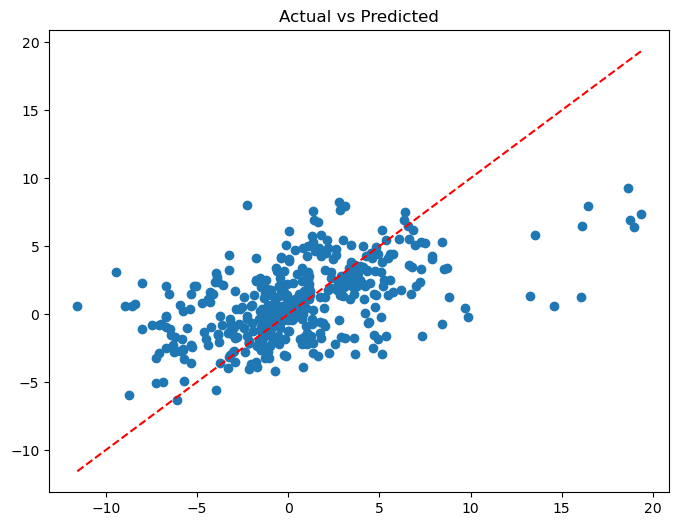



OLS Summary ZCH25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     14.38
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.15e-19
Time:                        16:45:30   Log-Likelihood:                -351.31
No. Observations:                 158   AIC:                             728.6
Df Residuals:                     145   BIC:                             768.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

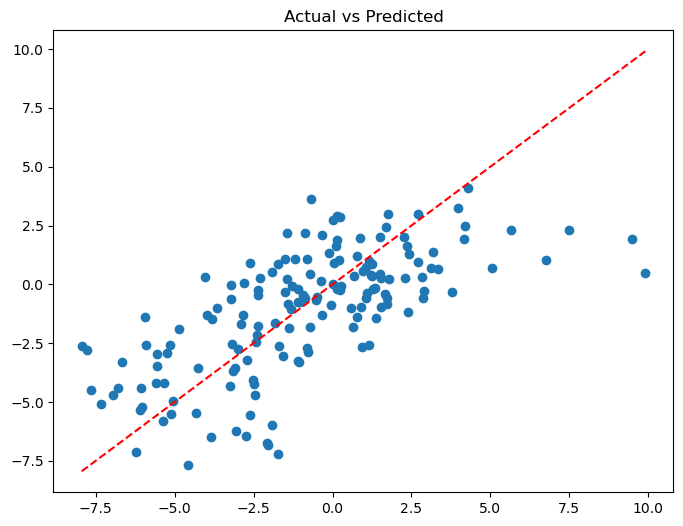



OLS Summary ZCK25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     16.67
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.29e-20
Time:                        16:45:31   Log-Likelihood:                -280.53
No. Observations:                 133   AIC:                             587.1
Df Residuals:                     120   BIC:                             624.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

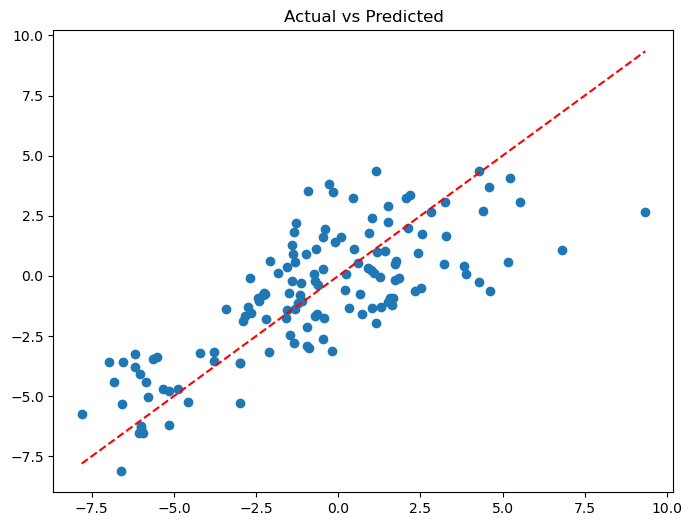



OLS Summary ZCN25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     33.89
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.13e-46
Time:                        16:45:31   Log-Likelihood:                -659.21
No. Observations:                 277   AIC:                             1344.
Df Residuals:                     264   BIC:                             1392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

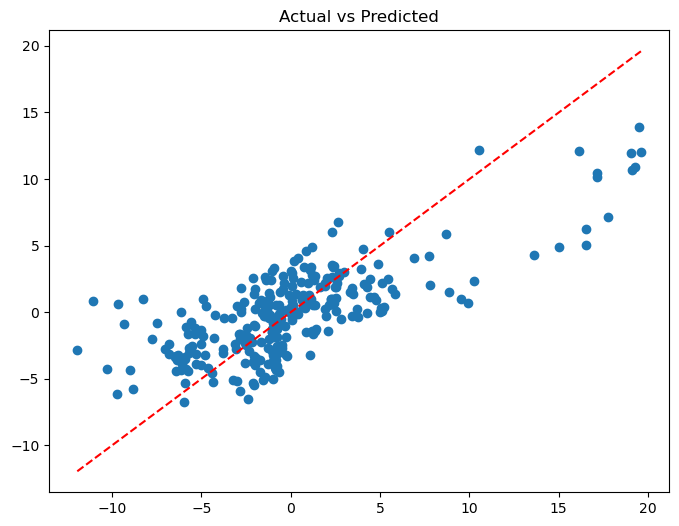



OLS Summary ZCU25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     32.16
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.71e-30
Time:                        16:45:31   Log-Likelihood:                -204.07
No. Observations:                 123   AIC:                             434.1
Df Residuals:                     110   BIC:                             470.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

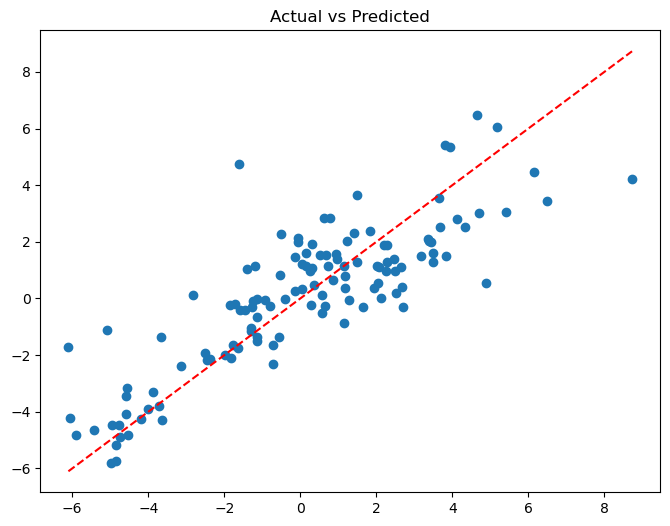



OLS Summary ZCZ25.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     38.42
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.44e-51
Time:                        16:45:32   Log-Likelihood:                -642.66
No. Observations:                 284   AIC:                             1311.
Df Residuals:                     271   BIC:                             1359.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

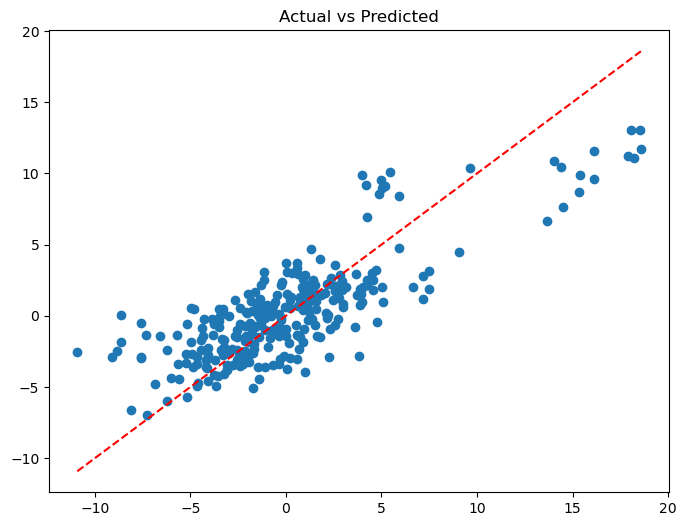



OLS Summary ZCH26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     10.56
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           3.44e-06
Time:                        16:45:32   Log-Likelihood:                -30.999
No. Observations:                  33   AIC:                             88.00
Df Residuals:                      20   BIC:                             107.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

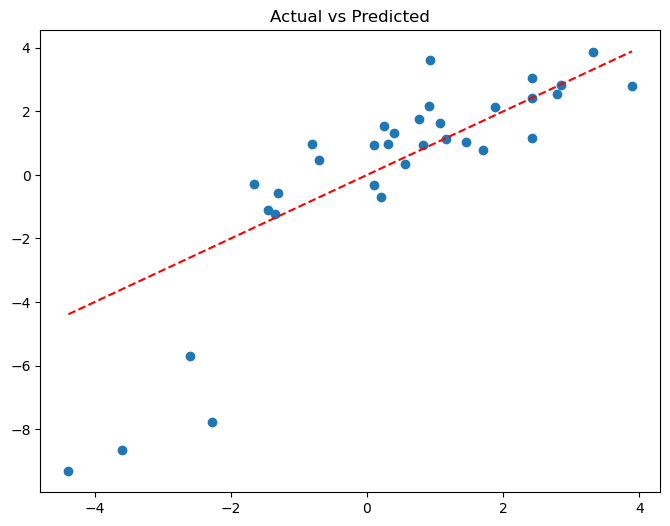



OLS Summary ZCK26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     15.49
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.46e-07
Time:                        16:45:33   Log-Likelihood:                -21.915
No. Observations:                  32   AIC:                             69.83
Df Residuals:                      19   BIC:                             88.89
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

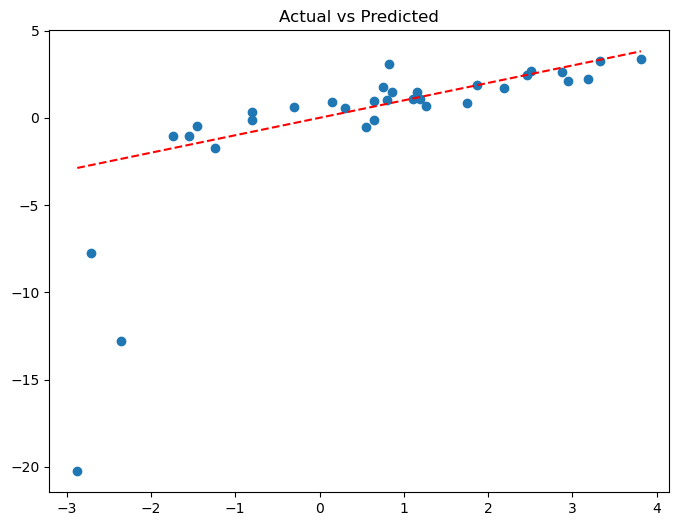



OLS Summary ZCN26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     28.93
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           9.87e-29
Time:                        16:45:33   Log-Likelihood:                -207.66
No. Observations:                 124   AIC:                             441.3
Df Residuals:                     111   BIC:                             478.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

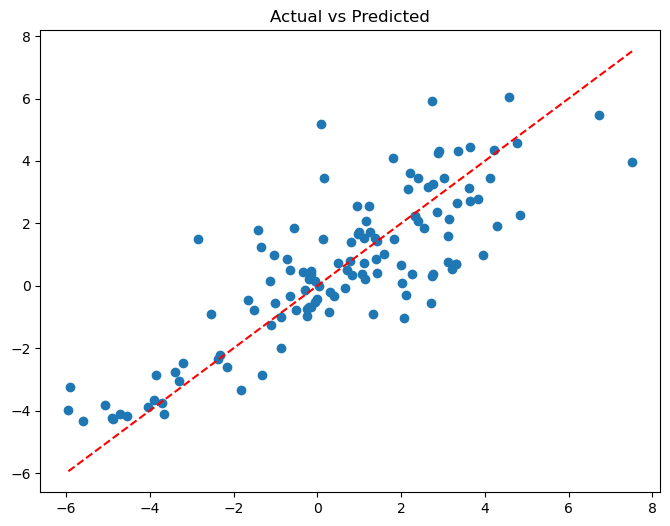



OLS Summary ZCU26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     14.67
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.26e-07
Time:                        16:45:33   Log-Likelihood:                -23.939
No. Observations:                  33   AIC:                             73.88
Df Residuals:                      20   BIC:                             93.33
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

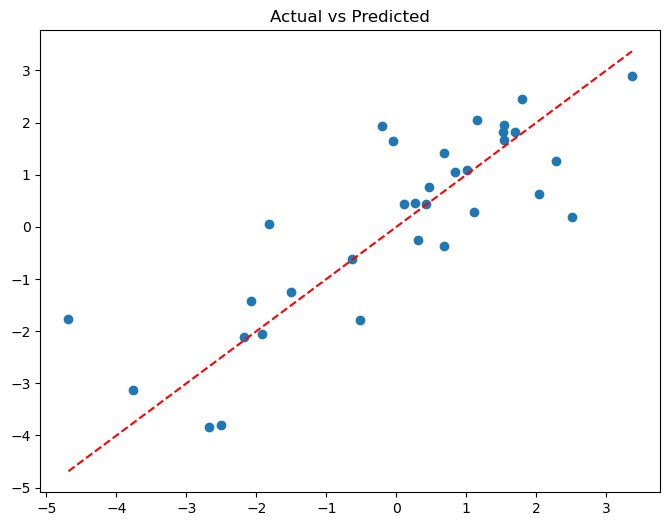



OLS Summary ZCZ26.CBT:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     18.06
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           2.74e-23
Time:                        16:45:34   Log-Likelihood:                -306.64
No. Observations:                 158   AIC:                             639.3
Df Residuals:                     145   BIC:                             679.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

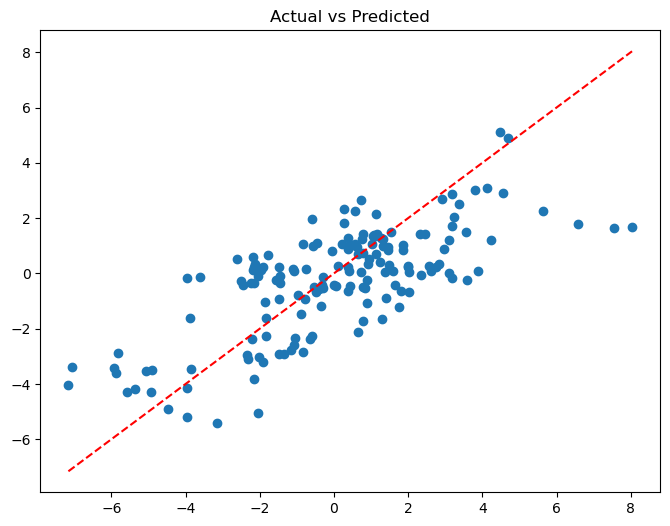

In [98]:
#Inputs for OLS 
OLS_models_dict = {}
for name, df in dfs_dct.items():
    print(f'OLS Summary {name}:')
    ols_model = ols(df)
    OLS_models_dict[name] = ols_model  # Store the ols model object in the dictionary
#so in OLS_models_dict we have the name of the contracts as key and the regression object as val
#so that we can create a trading strat based on the next month expected returns
    print('\n')

In [99]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [100]:
# Visualization: Actual vs Predicted
'''
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')\nplt.xlabel('Actual')\nplt.ylabel('Predicted')\nplt.title('Actual vs Predicted')\nplt.show()\n"

In [101]:
'''
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")
'''

'\n# Set up Optuna study\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=50)\n\n# Get the best hyperparameters\nbest_params = study.best_params\n\n# Train the model with the best hyperparameters\nrf_best = RandomForestRegressor(**best_params, random_state=42)\nrf_best.fit(X_train, y_train)\n\n# Evaluate the model\ny_pred = rf_best.predict(X_test)\nmae = mean_absolute_error(y_test, y_pred)\nrmse = root_mean_squared_error(y_test, y_pred)\nmse = mean_squared_error(y_test, y_pred)\n\nprint(f"Best Hyperparameters: {best_params}")\nprint(f"Mean Absolute Error (MAE): {mae:.2f}")\nprint(f"Root Mean Squared Error (RMSE): {rmse:.2f}")\nprint(f"Mean Squared Error(MSE): {mse:.2f}")\n'

In [102]:
'''
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

'\n# Visualization: Feature Importance\nfeature_importances = rf_best.feature_importances_\nsorted_indices = np.argsort(feature_importances)[::-1]\nplt.figure(figsize=(10, 6))\nplt.title("Feature Importances")\nplt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")\nplt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)\nplt.tight_layout()\nplt.show()\n\n# Visualization: Actual vs Predicted\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], \'--\', color=\'red\')\nplt.xlabel(\'Actual\')\nplt.ylabel(\'Predicted\')\nplt.title(\'Actual vs Predicted\')\nplt.show()\n'